In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import h5py
import numpy as np
import astropy.units as u
import astropy.constants as c
from scipy import stats

import powerbox as pbox
import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from analysis.limits import get_limits

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [2]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active"
dirs = {
    # 'decay' : "/decay/phot/log10m5.000",
    'pwave' : "/pwave-phot-250630/log10m5.000",
    'pbhhr' : "/pbhhr-a0.000/log10m16.500",
    "pbhacc" : "/pbhacc-PRc23-250630/log10m4.000",
}

m_s, _, sigma_s, _ = get_limits('pwave-phot-250630')
i = np.argmin(np.abs(m_s - 1e5))
print('pwave', sigma_s[i])
pwave_multiplier = sigma_s[i] * np.sqrt(stats.chi2.ppf(.9, df=1))

m_s, _, sigma_s, _ = get_limits('pbhhr-a0.000')
i = np.argmin(np.abs(m_s - 10**16.5))
print('pbhhr', sigma_s[i])
pbhhr_multiplier = sigma_s[i] * np.sqrt(stats.chi2.ppf(.9, df=1))

m_s, _, sigma_s, _ = get_limits('pbhacc-PRc23-250630')
i = np.argmin(np.abs(m_s - 1e4))
print('pbhacc', sigma_s[i])
pbhacc_multiplier = sigma_s[i] * np.sqrt(stats.chi2.ppf(.9, df=1))

multipliers = {
    'pwave' : pwave_multiplier,
    'pbhhr' : pbhhr_multiplier,
    "pbhacc" : pbhacc_multiplier,
}
bkg_fn = f"{outputs_dir}/../bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
inj_fn = "LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"

pwave 305.67594540608746
pbhhr 19.90076022493432
pbhacc 105.25154542931017


In [3]:
with h5py.File(bkg_fn, 'r') as hf:
    lcfield_bkg = hf['lightcones']['brightness_temp'][()]
    print(hf['lightcones'].keys())

lc_bkg = p21c.LightCone.read(bkg_fn)
z_s = lc_bkg.lightcone_redshifts

<KeysViewHDF5 ['Tk_box', 'Ts_box', 'brightness_temp', 'density', 'xH_box', 'x_e_box']>


In [4]:
lcs = {}
for k, v in dirs.items():
    fn = f"{outputs_dir}{v}/{inj_fn}"
    print(fn)
    with h5py.File(fn, 'r') as hf:
        lcs[k] = hf['lightcones']['brightness_temp'][()]

/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pwave-phot-250630/log10m5.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhhr-a0.000/log10m16.500/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250630/log10m4.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5


In [5]:
EoR_color = mpl.colors.LinearSegmentedColormap.from_list('EoR', [
    (0.0,  'yellow'),
    (0.25, 'orange'),
    (0.5,  'red'),
    (0.75, 'black'),
    (0.85, 'blue'),
    (0.95, 'cyan'),
    (1.0,  'cyan')
])
vmin, vmax = -60, 20 # 0 at 0.75
EoR_color_small = mpl.colors.LinearSegmentedColormap.from_list('EoRsmall', [
    (0.0, 'black'),
    (0.6, 'blue'),
    (1.0, 'cyan')
])

/tmp/ipykernel_1428368/1894351980.py:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)


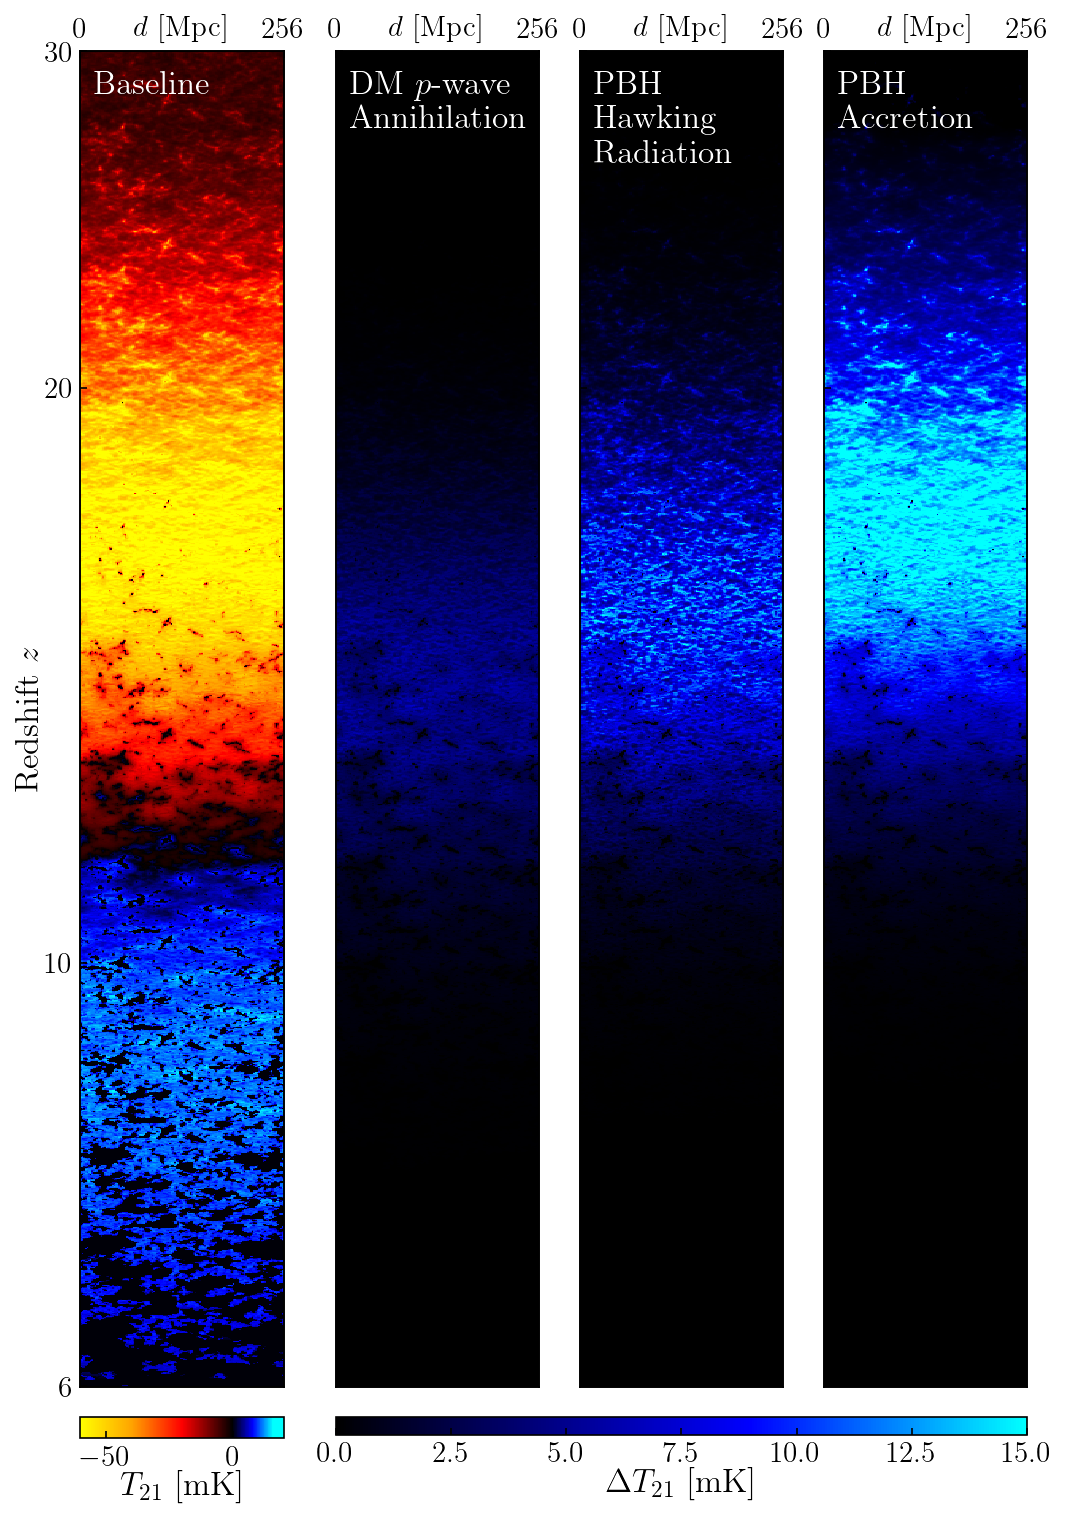

In [9]:
texts = {
    'pwave' : r'DM $p$-wave' + '\nAnnihilation',
    'pbhhr' : 'PBH \nHawking \nRadiation',
    "pbhacc" : 'PBH \nAccretion',
}

fig, axs = plt.subplots(1, 4, figsize=(7, 10), sharey='row', layout='constrained')

x_s = np.linspace(0, 256, 128)
z_start = 6.
z_end = 30.
i_z_start = np.argmin(np.abs(z_s-z_start)) - 1
i_z_end = np.argmin(np.abs(z_s-z_end)) + 1
z_s_plot = z_s[i_z_start:i_z_end]
lcplot_bkg = lcfield_bkg[:,0,i_z_start:i_z_end].T

ax = axs[0]
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg, cmap=EoR_color, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, aspect=10, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$T_{21}$ [mK]', labelpad=0, fontsize=16)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for i, (k, v) in enumerate(lcs.items()):
    lcplot = v[:,0,i_z_start:i_z_end].T
    ax = axs[i+1]
    m = multipliers[k]
    im = ax.pcolormesh(x_s, z_s_plot, (lcplot - lcplot_bkg) * m, cmap=EoR_color_small, vmin=0, vmax=15)
    ax.text(0.07, 0.985, texts[k], fontsize=16, color='w', transform=ax.transAxes, ha='left', va='top')

axs[0].text(0.07, 0.985, 'Baseline', fontsize=16, color='w', transform=axs[0].transAxes, ha='left', va='top')

cbar = fig.colorbar(im, ax=axs[1:], aspect=40, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$\Delta T_{21}$ [mK]', labelpad=0, fontsize=16)

for ax in axs:
    ax.set(yscale='log', xticks=[])
    axt = ax.twiny()
    axt.set_xticks([0, 256])
    axt.set_xlabel(r'$d$ [Mpc]', labelpad=-9)
    ax.invert_yaxis()

# axs[0].set_title(r'No injection $T_b$ [mK]')
# axs[1].set_title(r'Inhom. injection $T_b-$ No injection $T_b$ [mK]')
# axs[2].set_title(r'Hom. injection $T_b-$ No injection $T_b$ [mK]')

axs[0].set_ylabel('Redshift $z$', labelpad=0, fontsize=16)
axs[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].set_yticks([6, 10, 20, 30])
axs[0].set_yticklabels([6, 10, 20, 30])

# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig("../plotting/paper2/inj_scenarios.png", dpi=200)